<a href="https://colab.research.google.com/github/atikanurzida/panel_regression_analysis/blob/main/Analisis_Regresi_Data_Panel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Analisis faktor pendidikan dan gini coefficient terhadap kemiskinan

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # untuk standardisasi data
!pip install pandas statsmodels linearmodels # harus diinstal
import statsmodels.api as sm
from linearmodels.panel import PooledOLS, PanelOLS # untuk modeling
from scipy import stats # untuk uji chow
from scipy.stats import jarque_bera # untuk uji normalitas
from scipy.stats import skew, kurtosis
from statsmodels.stats.diagnostic import het_breuschpagan # untuk uji heteroskedastisitas

In [57]:
from google.colab import files
uploaded = files.upload()

Saving Indonesia_poverty_2.xlsx to Indonesia_poverty_2 (2).xlsx


In [ ]:
# data untuk kemiskinan
data = pd.read_excel('Socio_Demographic.xlsx',sheet_name="Poverty_Stat")

In [58]:
# all data yang dibutuhkan untuk analisis
data1= pd.read_excel('Indonesia_poverty_2.xlsx',sheet_name="Sheet1")

Preprocessing Data

In [ ]:
# hapus baris dengan index kolom pertama
data = data.dropna(how='all', subset=data.columns[1:])

In [ ]:
# harus kolom dengan index baris pertama
data = data.loc[:, data.iloc[1:].notna().any(axis=0)] #drop colomn are blanks exc row 1

In [ ]:
# Convert kolom tgl ke format date
data['Select this link and click Refresh/Edit Download to update data and add or remove series'] = pd.to_datetime(data['Select this link and click Refresh/Edit Download to update data and add or remove series'], format='%d-%m-%Y', errors='coerce')
# Extract tahun dari kolom tgl
data['Year'] = data['Select this link and click Refresh/Edit Download to update data and add or remove series'].dt.year
data = data.groupby('Year').agg({
    'Number of Poor People: East Java (Indonesia)': 'sum',
    'Number of Poor People: West Java (Indonesia)': 'sum',
    'Number of Poor People: Central Java (Indonesia)': 'sum',
    'Number of Poor People: North Sumatera (Indonesia)': 'sum',
    'Number of Poor People: East Nusa Tenggara (Indonesia)': 'sum'
}).reset_index()

In [ ]:
#download hasil data
data.to_excel("kemiskinan indonesia.xlsx")

Cleaning Data

In [5]:
# Cek missing values
print(data1.isnull().sum().sum())

0


Statistik Deskriptif

In [27]:
# Menampilkan statistik deskriptif
print(data1.describe().round(2))

          Year  Education  Gini_Coefficient  Indonesia_Poverty
count    56.00      56.00             56.00              56.00
mean   2013.50   46503.50              0.37             634.51
std       4.07   27095.26              0.04             367.60
min    2007.00   10278.00              0.30             208.58
25%    2010.00   27341.75              0.35             296.96
50%    2013.50   41758.00              0.37             557.00
75%    2017.00   51653.50              0.40             982.48
max    2020.00  114722.00              0.44            1163.60


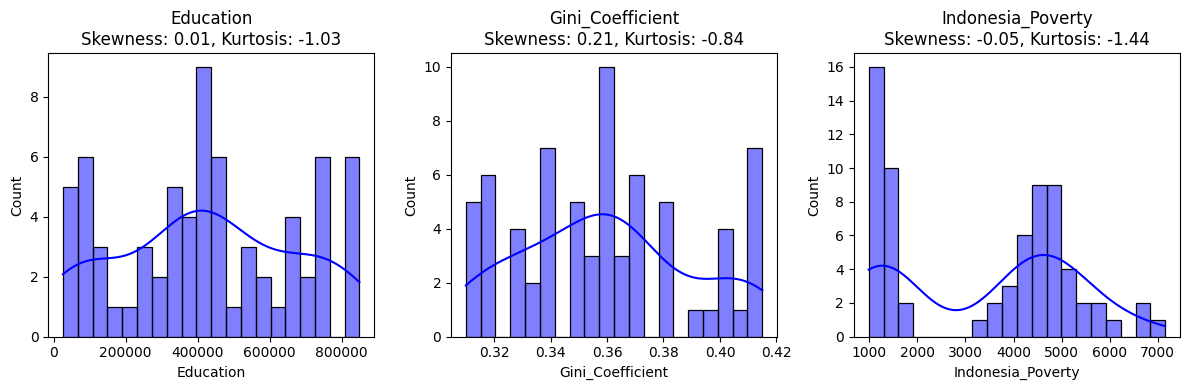

In [10]:
columns_to_plot = ["Education", "Gini_Coefficient", "Indonesia_Poverty"]

# Buat histogram untuk setiap variabel
plt.figure(figsize=(12, 4))

for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data1[col], bins=20, kde=True, color='blue', edgecolor='black')

    # Hitung skewness dan kurtosis
    skewness = skew(data1[col].dropna())
    kurt = kurtosis(data1[col].dropna())

    plt.title(f"{col}\nSkewness: {skewness:.2f}, Kurtosis: {kurt:.2f}")

plt.tight_layout()
plt.show()

Standardisasi Data

In [59]:
scaler = StandardScaler()

In [60]:
data1[['Education', 'Gini_Coefficient', 'Indonesia_Poverty']] = scaler.fit_transform(data1[['Education', 'Gini_Coefficient', 'Indonesia_Poverty']])

In [47]:
print(data1)

               Province  Year  Education  Gini_Coefficient  Indonesia_Poverty
0            Jawa Timur  2007  -0.368818         -0.645848           2.039423
1            Jawa Timur  2008   0.059806         -0.978025           1.711093
2            Jawa Timur  2009   0.182134         -0.978025           1.338357
3            Jawa Timur  2010   0.498835         -0.645848           1.186024
4            Jawa Timur  2011   0.759204          0.350684           0.995080
..                  ...   ...        ...               ...                ...
65  Nusa Tenggara Timur  2016  -1.440821         -0.778718          -1.212677
66  Nusa Tenggara Timur  2017  -1.315144         -0.014711          -1.212206
67  Nusa Tenggara Timur  2018  -1.290147         -0.014711          -1.216874
68  Nusa Tenggara Timur  2019  -1.278730         -0.114364          -1.214626
69  Nusa Tenggara Timur  2020  -1.286023         -0.180799          -1.210597

[70 rows x 5 columns]


MODELING

In [61]:
# set index untuk entitas dan tahun
data1['Province'] = data1['Province'].astype('category')
data1['Year'] = pd.to_datetime(data1['Year'], format='%Y').dt.year
data1 = data1.set_index(['Province', 'Year'])

In [62]:
# Mendefinisikan X dan Y
X = data1[["Education", "Gini_Coefficient"]]
y = data1["Indonesia_Poverty"]
# Menambahkan konstanta
X = sm.add_constant(X)

In [63]:
# Buat Common Effect Model (CEM)
common_model = sm.OLS(y, X).fit()
print("\n=== Common Effect Model ===")
print(common_model.summary())


=== Common Effect Model ===
                            OLS Regression Results                            
Dep. Variable:      Indonesia_Poverty   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     17.67
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           6.87e-07
Time:                        06:25:41   Log-Likelihood:                -84.500
No. Observations:                  70   AIC:                             175.0
Df Residuals:                      67   BIC:                             181.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const      

In [65]:
# Buat Fixed Effect Model (FEM)
fixed_model = PanelOLS(y, X.drop(columns="const"), entity_effects=True).fit()
print("\n=== Fixed Effect Model ===")
print(fixed_model.summary)


=== Fixed Effect Model ===
                          PanelOLS Estimation Summary                           
Dep. Variable:      Indonesia_Poverty   R-squared:                        0.7719
Estimator:                   PanelOLS   R-squared (Between):             -1.1580
No. Observations:                  70   R-squared (Within):               0.7719
Date:                Sun, Mar 23 2025   R-squared (Overall):             -0.9713
Time:                        06:25:53   Log-likelihood                    34.165
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      106.60
Entities:                           5   P-value                           0.0000
Avg Obs:                       14.000   Distribution:                    F(2,63)
Min Obs:                       14.000                                           
Max Obs:                       14.000   F-statistic (robust):             106.60


/usr/local/lib/python3.11/dist-packages/linearmodels/panel/data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/usr/local/lib/python3.11/dist-packages/linearmodels/panel/data.py:590: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/usr/local/lib/python3.11/dist-packages/linearmodels/panel/data.py:680: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to

Uji Chow

In [71]:
# Uji Chow (untuk membandingkan FEM dan CEM)
# 1. Hitung Statistik Uji Chow
N = data1.index.get_level_values("Province").nunique()  # Jumlah Provinsi yang dibutuhkan dalam analisis
T = data1.index.get_level_values("Year").nunique()  # Jumlah periode waktu
K = X.shape[1]  # Jumlah variabel independen
# Hitung Sum of Square Residuals dari CEM dan FEM
SSR_CEM = common_model.ssr
SSR_FEM = np.sum(fixed_model.resids ** 2)
# F-statistic
F_stat = ((SSR_CEM - SSR_FEM) / (N - 1)) / (SSR_FEM / (N * (T - 1) - K))
p_value = 1 - stats.f.cdf(F_stat, N - 1, N * (T - 1) - K)

In [72]:
# **Hasil Uji Chow**
print("\n=== Uji Chow ===")
print(f"F-Statistic: {F_stat}")
print(f"P-Value: {p_value}")

# Kesimpulan
if p_value < 0.05:
    print("H0 ditolak sehingga model terbaik adalah Fixed Effect Model")
else:
    print("H0 diterima sehingga model terbaik adalah Common Effect Model")


=== Uji Chow ===
F-Statistic: 444.5137128958413
P-Value: 1.1102230246251565e-16
H0 ditolak sehingga model terbaik adalah Fixed Effect Model


Asumsi Klasik

In [81]:
# Uji Normalitas
# Ambil residual dari model Fixed Effect
residuals = fixed_model.resids

# Uji normalitas Jarque-Bera
jb_stat, p_value = jarque_bera(residuals)

In [82]:
# Tampilkan hasil
print(f"Jarque-Bera Statistic: {jb_stat}")
print(f"P-Value: {p_value}")

# Interpretasi hasil
alpha = 0.05
if p_value < alpha:
    print("H0 ditolak sehingga data tidak berdistribusi normal")
else:
    print("H0 diterima sehingga data berdistribusi normal")

Jarque-Bera Statistic: 3.311901963810095
P-Value: 0.1909104169995407
H0 diterima sehingga data berdistribusi normal


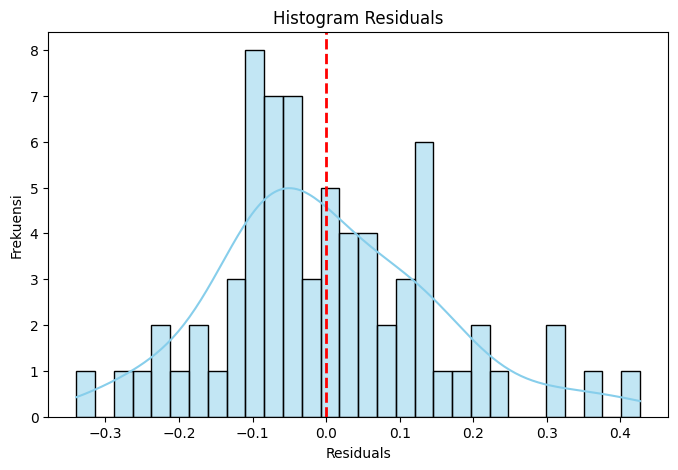

In [83]:
# Grafik histogram untuk uji normalitas
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True, color="skyblue")
plt.axvline(residuals.mean(), color='red', linestyle='dashed', linewidth=2)  # Garis rata-rata
plt.title("Histogram Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frekuensi")
plt.show()

In [91]:
# Uji heteroskedastisitas
bp_test = het_breuschpagan(fixed_model.resids, X)
bp_p_value = bp_test[1]  # p-value dari uji BP


In [95]:
# Hasil Uji Heteroskedastisitas
print("\n=== Uji Heteroskedastisitas ===")
if bp_p_value < 0.05:
    print(f"P-Value: {bp_p_value}")
    print("H0 ditolak sehingga terdapat heteroskedastisitas")
else:
    print(f"P-Value: {bp_p_value}")
    print("H0 diterima sehingga tidak ada heteroskedastisitas")


=== Uji Heteroskedastisitas ===
P-Value: 0.21966504737367756
H0 diterima sehingga tidak ada heteroskedastisitas


In [ ]:
data.to_excel("indonesia_poverty.xlsx")

In [ ]:
data.to_excel("standardisasi.xlsx")